In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
pd.options.display.max_rows = 7

In [2]:
# HIDDEN
students = pd.read_csv('roster.csv')
students['Name'] = students['Name'].str.lower()

## What's in a Name?

So far, we have asked a broad question about our data: "Do the first names of students in Data 100 tell us anything about the class?"

We have done a bit of data cleaning by converting all our names to lowercase. During our exploratory data analysis we discovered that our roster contains about 270 names of students in the class and on the waitlist, and that most of our first names are between 4 and 8 characters long.

What else can we discover about our class based on first names? We might consider a single name from our dataset:

In [3]:
students['Name'][5]

'jerry'

From this name we can infer that the student is likely a male. We can also take a guess at the student's age. For example, if we happen to know that Jerry was a very popular baby name in 1998, we might guess that this student is around twenty years old.

This thinking gives us two new questions to investigate:

1. "Do the first names of students in Data 100 tell us the distribution of sex in the class?"
1. "Do the first names of students in Data 100 tell us the distribution of ages in the class?"

In order to investigate these questions, we will need a dataset that associates names with sex and year. Conveniently, the US Social Security department hosts such a dataset online: https://www.ssa.gov/oact/babynames/index.html. Their dataset records the names given to babies at birth and as such is often referred to as the Baby Names dataset.

We will start by downloading and then loading the dataset into Python. Again, don't worry about understanding the code in this first chapter. It's more important that you understand the overall process.

[zipfile]: https://en.wikipedia.org/wiki/Zip_(file_format)

In [4]:
import urllib.request
import os.path

data_url = "https://www.ssa.gov/oact/babynames/names.zip"
local_filename = "babynames.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())
        
import zipfile
babynames = [] 
with zipfile.ZipFile(local_filename, "r") as zf:
    data_files = [f for f in zf.filelist if f.filename[-3:] == "txt"]
    def extract_year_from_filename(fn):
        return int(fn[3:7])
    for f in data_files:
        year = extract_year_from_filename(f.filename)
        with zf.open(f) as fp:
            df = pd.read_csv(fp, names=["Name", "Sex", "Count"])
            df["Year"] = year
            babynames.append(df)
babynames = pd.concat(babynames)
babynames

,Name,Sex,Count,Year
0,Mary,F,9217,1884
1,Anna,F,3860,1884
2,Emma,F,2587,1884
...,...,...,...,...
2081,Verna,M,5,1883
2082,Winnie,M,5,1883
2083,Winthrop,M,5,1883


In [6]:
ls -alh babynames.csv

-rw-r--r--  1 sam  staff    30M Jan 22 15:31 babynames.csv


It looks like the dataset contains names, the sex given to the baby, the number of babies with that name, and the year of birth for those babies. To be sure, we check the dataset description from the SSN Office: https://www.ssa.gov/oact/babynames/background.html

> All names are from Social Security card applications for births that occurred in the United States after 1879. Note  that many people born before 1937 never applied for a Social Security card, so their names are not included in our data. For others who did apply, our records may not show the place of birth, and again their names are not included in our data.
> 
> All data are from a 100% sample of our records on Social Security card applications as of March 2017.

A useful visualization for this data is to plot the number of male and female babies born each year:

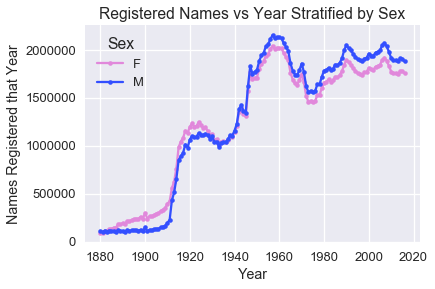

In [68]:
pivot_year_name_count = pd.pivot_table(
    babynames, index='Year', columns='Sex',
    values='Count', aggfunc=np.sum)

pink_blue = ["#E188DB", "#334FFF"]
with sns.color_palette(sns.color_palette(pink_blue)):
    pivot_year_name_count.plot(marker=".")
    plt.title("Registered Names vs Year Stratified by Sex")
    plt.ylabel('Names Registered that Year')

This plot makes us question whether the US had babies in 1880. A sentence from the quote above helps explain:

> Note that many people born before 1937 never applied for a Social Security card, so their names are not included in our data. For others who did apply, our records may not show the place of birth, and again their names are not included in our data.

We can also see the [baby boomer period](https://www.wikiwand.com/en/Baby_boomers) quite clearly in the plot above.

### Inferring Sex From Name

Let's use this dataset to estimate the number of females and males in our class. As with our class roster, we begin by lowercasing the names:

In [63]:
babynames['Name'] = babynames['Name'].str.lower()
babynames

,Name,Sex,Count,Year
0,mary,F,9217,1884
1,anna,F,3860,1884
2,emma,F,2587,1884
...,...,...,...,...
2081,verna,M,5,1883
2082,winnie,M,5,1883
2083,winthrop,M,5,1883


Then, we count up how many male and female babies were born in total for each name:

In [58]:
sex_counts = pd.pivot_table(babynames, index='Name', columns='Sex', values='Count',
                            aggfunc='sum', fill_value=0., margins=True)
sex_counts

Sex,F,M,All
Name,,,
aaban,0,96,96
aabha,35,0,35
aabid,0,10,10
...,...,...,...
zyyon,0,6,6
zzyzx,0,5,5
All,170639571,173894326,344533897


To decide whether a name is male or female, we can compute the proportion of times the name was given to a female baby.

In [59]:
prop_female = sex_counts['F'] / sex_counts['All']
sex_counts['prop_female'] = prop_female
sex_counts

Sex,F,M,All,prop_female
Name,,,,
aaban,0,96,96,0.000000
aabha,35,0,35,1.000000
aabid,0,10,10,0.000000
...,...,...,...,...
zyyon,0,6,6,0.000000
zzyzx,0,5,5,0.000000
All,170639571,173894326,344533897,0.495277


We can then define a function that looks up the proportion of female names given a name.

In [60]:
def sex_from_name(name):
    if name in sex_counts.index:
        prop = sex_counts.loc[name, 'prop_female']
        return 'F' if prop > 0.5 else 'M'
    else:
        return None
sex_from_name('sam')

'M'

Try typing some names in this box to see whether the function outputs what you expect:

In [71]:
interact(sex_from_name, name='sam');

A Jupyter Widget

We mark each name in our class roster with its most likely sex.

In [61]:
students['sex'] = students['Name'].apply(sex_from_name)
students

,Name,Role,sex
0,keeley,Student,F
1,john,Student,M
2,bryan,Student,M
...,...,...,...
276,ernesto,Waitlist Student,M
277,athan,Waitlist Student,M
278,michael,Waitlist Student,M


Now it is easy to estimate how many male and female students we have:

In [64]:
students['sex'].value_counts()

M    144
F     92
Name: sex, dtype: int64

### Inferring Age From Name

We can proceed in a similar way to estimate the age distribution of the class, mapping each name to its average age in the dataset.

In [92]:
def avg_year(group):
    return np.average(group['Year'], weights=group['Count'])

avg_years = (
    babynames
    .groupby('Name')
    .apply(avg_year)
    .rename('avg_year')
    .to_frame()
)
avg_years

,avg_year
Name,
aaban,2012.572917
aabha,2013.714286
aabid,2009.500000
...,...
zyyanna,2010.000000
zyyon,2014.000000
zzyzx,2010.000000


In [108]:
def year_from_name(name):
    return (avg_years.loc[name, 'avg_year']
            if name in avg_years.index
            else None)

# Generate input box for you to try some names out:
interact(year_from_name, name='fernando');

A Jupyter Widget

In [104]:
students['year'] = students['Name'].apply(year_from_name)
students

,Name,Role,sex,year
0,keeley,Student,F,1998.147952
1,john,Student,M,1951.084937
2,bryan,Student,M,1983.565113
...,...,...,...,...
276,ernesto,Waitlist Student,M,1981.439873
277,athan,Waitlist Student,M,2004.397863
278,michael,Waitlist Student,M,1971.179231


Then, it is easy to plot the distribution of years:

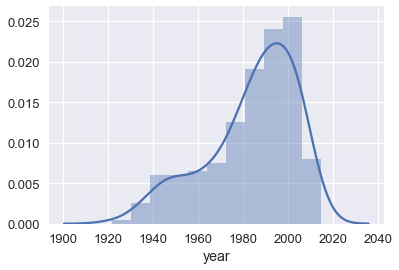

In [150]:
sns.distplot(students['year'].dropna());

To compute the average year:

In [106]:
students['year'].mean()

1983.846741800525

Which makes it appear like the average student is 35 years old. This is a course for college undergrads, so we were expecting an average age of around 20. Why might our estimate be so far off?

As data scientists, we often run into results that don't agree with our expectations and must make judgement calls about whether our results were caused by our data, our processes, or incorrect hypotheses. It is impossible to define rules that apply to every situation. Instead, we will give you the tools to re-examine each step of your data analysis and show you how to use them.

In this case, the most likely possibility for our unexpected result is that most names are old. For example, the name John was quite popular throughout the history recorded in our data, which means that we'd likely guess that a person named John is born around 1950. We can confirm this by looking at the data:

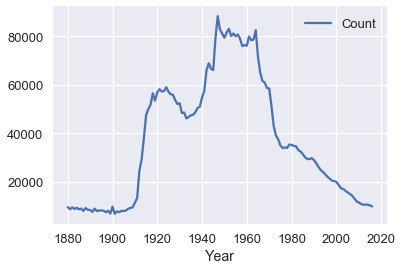

In [149]:
names = babynames.set_index('Name').sort_values('Year')
john = names.loc['john']
john[john['Sex'] == 'M'].plot('Year', 'Count');

If we happen to believe that no one in our class is over the age of 40 or under the age of 10 (we might find out by looking at our classroom during lecture) we can incorporate this into our analysis by only examining the data between 1978 and 2008. We will soon discuss data manipulation and you may revisit this analysis to find out if incorporating this prior belief gives a more sensible result.